In [4]:
from tinylang.language import PCFG
import pandas as pd
import plotnine as p9
from tqdm import tqdm
from copy import deepcopy

In [73]:
defaults = {
    "class": "PCFG",
    "config": {
        "num_terminals": 40,
        "num_nonterminals": 80,
        "max_rhs_len": 10,
        "max_rules_per_nt": 5,
        "max_depth": 10,
        "head_position": "right",
        "mask_nonquery": True,
        "no_sibling_queries": True,
        "no_child_queries": True,
        "unambiguous_queries": True,
        "sample_first": "query",
    }
}

ablations = {
    # "num_terminals": [5, 10, 20, 40, 80, 160],
    # "num_nonterminals": [5, 10, 20, 40, 80, 160],
    # "max_rhs_len": [2, 4, 6, 8, 10, 12, 14, 16],
    "max_rules_per_nt": [1, 2, 4, 5, 10, 20, 40],
    # "max_depth": [0, 2, 4, 8, 10, 20, 40],
}

max_rules_per_nt: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.05it/s]


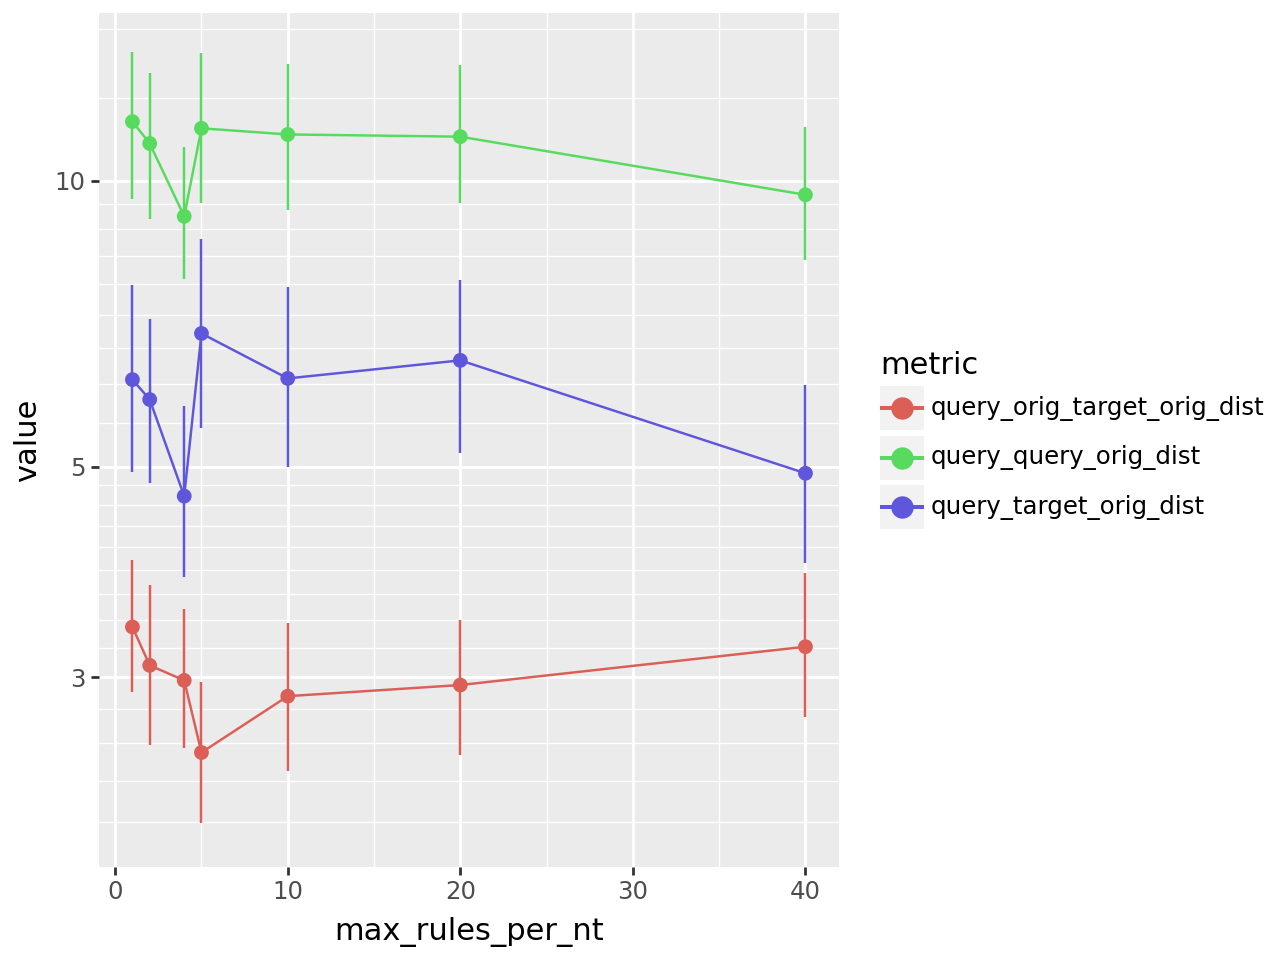

In [74]:
for ablation in ablations:
    metrics = []
    num_samples = 100
    for ablation_val in tqdm(ablations[ablation], desc=ablation):
        orig = defaults["config"][ablation]
        defaults["config"][ablation] = ablation_val
        lang = PCFG.from_config(defaults)
        lang.prepare_sets(1, 1, 0, num_samples)
        lang.stats
        for i in range(num_samples):
            for key in lang.stats["test"]:
                if len(lang.stats["test"][key]) != num_samples:
                    continue
                val = lang.stats["test"][key][i]
                metrics.append({
                    "metric": key,
                    "value": val,
                    ablation: ablation_val,
                })
        defaults["config"][ablation] = orig

        df = pd.DataFrame(metrics)
        # print(ablation_val)
        # for metric in df["metric"].unique():
        #     print(metric, df[(df["metric"] == metric) & (df[ablation] == ablation_val)]["value"].mean())
        # print()

    df = pd.DataFrame(metrics)
    # df[ablation] = pd.Categorical(df[ablation])
    # print(df)
    plot = (
        p9.ggplot(df[df["metric"].str.endswith("dist")], p9.aes(x=ablation, y="value", color="metric")) + p9.stat_summary(geom="line") + p9.stat_summary(geom="pointrange") +
        p9.scale_y_log10()
    )
    plot.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/it]


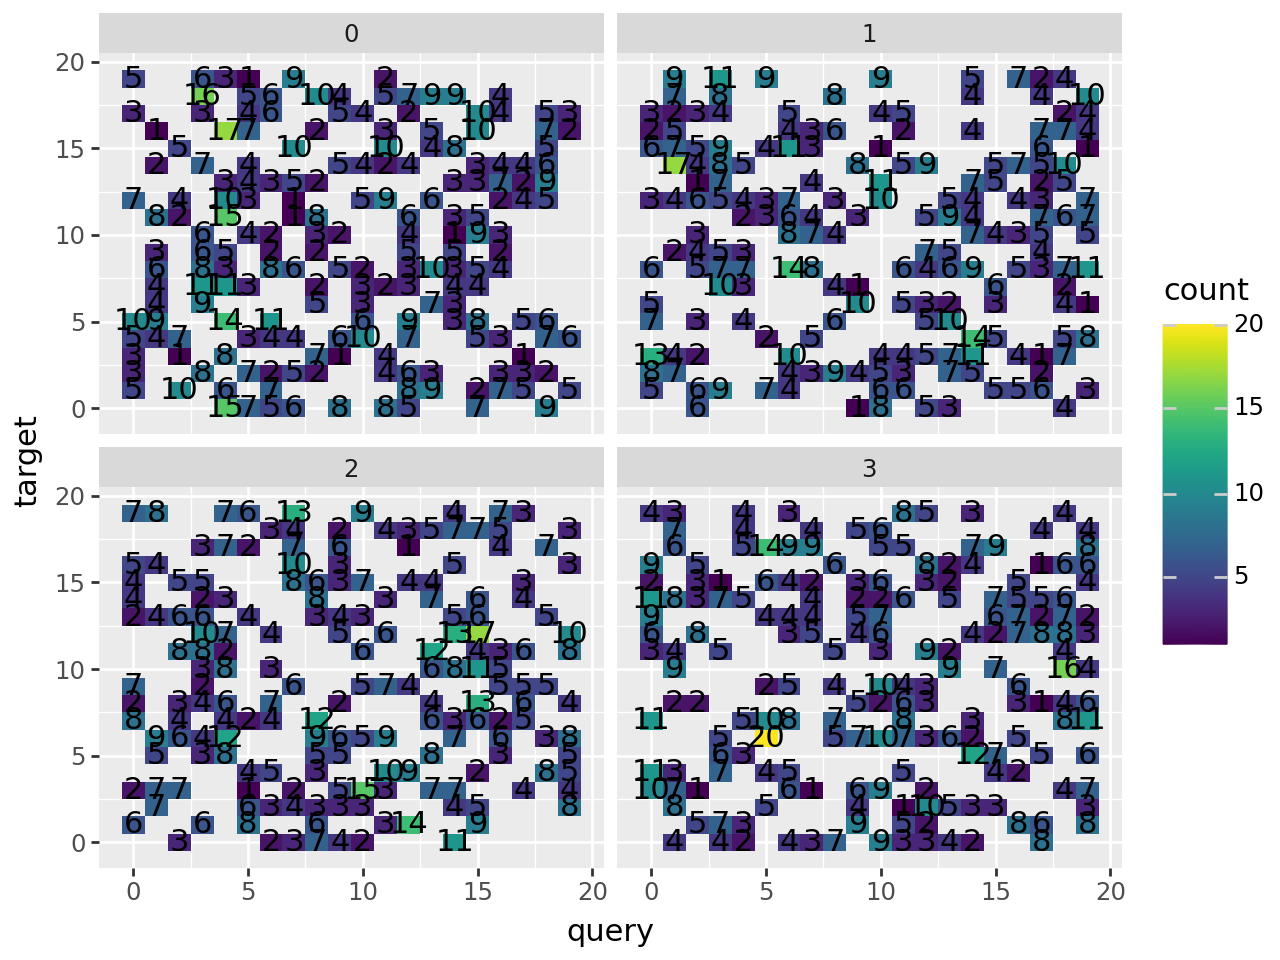

In [59]:
defaults = {
    "class": "PCFG",
    "config": {
        "num_terminals": 40,
        "num_nonterminals": 80,
        "max_rhs_len": 10,
        "max_rules_per_nt": 100,
        "max_depth": 10,
        "head_position": "right",
        "mask_nonquery": True,
        "no_sibling_queries": True,
        "no_child_queries": True,
        # "transparent_nonterminals": True,
        "unambiguous_queries": True,
        "sample_first": "query",
    }
}

N = 4
ablations_paired = {
    "num_terminals": [20 for i in range(1, N + 1)],
    # "num_nonterminals": [i * 40 for i in range(1, N + 1)],
    "num_nonterminals": [40 for i in range(1, N + 1)],
    "max_rhs_len": [i + 2 for i in range(1, N + 1)],
}

metrics = []
KV_pairs = []
for idx in tqdm(range(len(list(ablations_paired.values())[0]))):
    num_samples = 1000
    new_config = deepcopy(defaults)
    for ablation in ablations_paired:
        ablation_val = ablations_paired[ablation][idx]
        new_config["config"][ablation] = ablation_val
        
    lang = PCFG.from_config(new_config)
    lang.prepare_sets(1, 1, 0, num_samples)
    for schema in lang.evalsets["test"]["probing_schemas"]:
        KV_pairs.append({
            "index": idx,
            "query": schema["target_distributions"]["query_item_orig"],
            "target": schema["target_distributions"]["target_item_orig"],
            "count": 1,
        })
    # print(lang.evalsets["test"]["probing_schemas"][0]["target_distributions"])
    # break
    # lang.stats
    
    for i in range(num_samples):
        for key in lang.stats["test"]:
            if len(lang.stats["test"][key]) != num_samples:
                continue
            val = lang.stats["test"][key][i]
            metrics.append({
                "metric": key,
                "value": val,
                "index": idx,
            })

KV_pairs = pd.DataFrame(KV_pairs).groupby(["index", "query", "target"]).sum().reset_index()
plot = (
    p9.ggplot(KV_pairs, p9.aes(x="query", y="target", fill="count", label="count")) + p9.geom_tile() + p9.geom_text() +
    p9.facet_wrap("~index")
)
plot.show()
            
# df = pd.DataFrame(metrics)
# plot = (
#     p9.ggplot(df[df["metric"].str.endswith("dist")], p9.aes(x="index", y="value", group="index")) +
#     p9.facet_wrap("~metric") +
#     p9.geom_boxplot() +
#     # p9.stat_summary(geom="line") + p9.stat_summary(geom="pointrange") +
#     p9.scale_y_log10()
# )
# plot.show()

# for m in df["metric"].unique():
#     if m.endswith("dist"): continue
#     plot = (
#         p9.ggplot(df[df["metric"] == m], p9.aes(x="index", y="value", color="metric")) + p9.stat_summary(geom="line") + p9.stat_summary(geom="pointrange") +
#         p9.scale_y_log10()
#     )
#     plot.show()

# for m in df[df["metric"].str.endswith("dist")]["metric"].unique():
#     plot = (
#         p9.ggplot(df[df["metric"] == m], p9.aes(x="value", fill="metric")) +
#         p9.facet_wrap("~index") +
#         p9.geom_histogram(binwidth=1) +
#         p9.scale_y_log10()
#     )
#     plot.show()

In [ ]:
df = pd.DataFrame(metrics)
df[a] = pd.Categorical(df[a])
df[b] = pd.Categorical(df[b])
for metric in df["metric"].unique():
    subset_df = df[df["metric"] == metric]
    plot = (
        p9.ggplot(subset_df, p9.aes(x=a, y=b, fill="value")) + p9.geom_tile() + p9.labs(title=metric)
        + p9.geom_text(p9.aes(label="value"))
    )
    plot.show()